In [4]:
from __future__ import print_function
import math 

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf 
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [5]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [7]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
7082,-118.3,34.0,50.0,1389.0,364.0,976.0,302.0,1.6,327.3
16299,-122.5,37.5,21.0,1209.0,309.0,801.0,259.0,4.6,500.0
4075,-118.0,34.1,27.0,6341.0,1289.0,2899.0,1192.0,3.6,235.2
3268,-117.9,33.7,30.0,2651.0,572.0,3249.0,552.0,3.7,182.1
10580,-120.5,34.6,34.0,2571.0,499.0,1105.0,451.0,3.8,150.0
...,...,...,...,...,...,...,...,...,...
13036,-121.9,37.2,18.0,7245.0,1029.0,2893.0,1049.0,7.0,361.2
14899,-122.2,38.1,29.0,5154.0,1084.0,2459.0,1019.0,3.3,142.9
15579,-122.3,37.6,52.0,2635.0,408.0,967.0,374.0,7.0,500.0
5611,-118.2,34.1,8.0,1116.0,267.0,435.0,235.0,4.9,230.9


In [9]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [14]:
# Difine the input feature : total room
my_feature = california_housing_dataframe[["total_rooms"]]
feature_columns =[tf.feature_column.numeric_column("total_rooms")] # 데이터가 숫자임을 지정 

In [11]:
# Define the label 
targets = california_housing_dataframe["median_house_value"]

In [15]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer=my_optimizer
)

In [18]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items() }
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [20]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [25]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean squared Error : %0.3f" % mean_squared_error)
print("root Mean squared Error : %0.3f" % root_mean_squared_error)

Mean squared Error : 56308.999
root Mean squared Error : 237.295


In [27]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value


print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.295


In [28]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.3,207.3
std,0.2,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.2,180.4
75%,0.3,265.0
max,3.8,500.0


In [29]:
sample = california_housing_dataframe.sample(n=300)

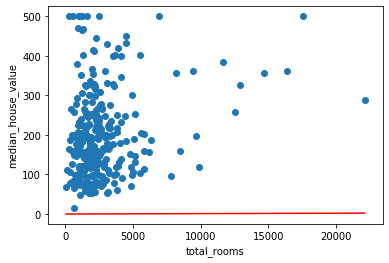

In [35]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

In [36]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90


  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13


  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


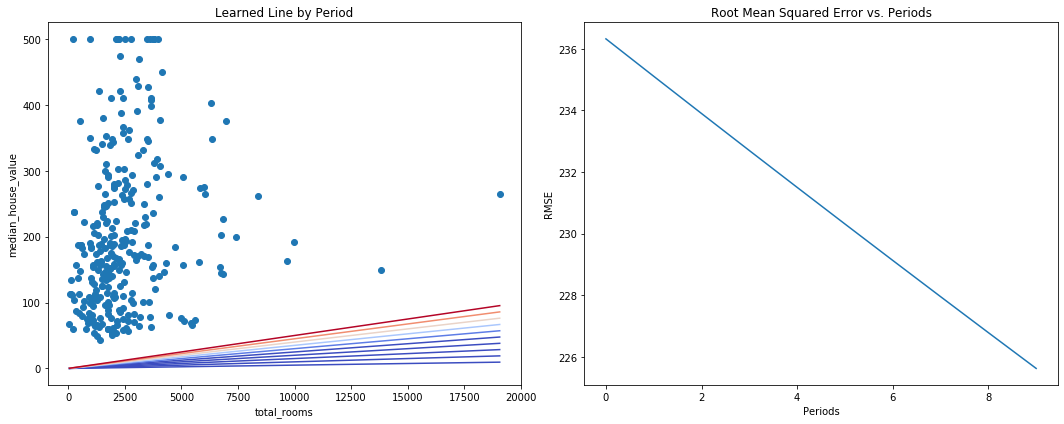

In [37]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

In [53]:
def train_model_pop(learning_rate, steps, batch_size, input_feature="population"):
    periods = 10
    step_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    targets = california_housing_dataframe["median_house_value"]
    
    feature_columns = [tf.feature_column.numeric_column(my_feature)]

    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(        
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel("median_house_value")
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample["median_house_value"])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    root_mean_squared_errors=[]
    
    for period in range (0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=step_per_period
        )
        
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        root_mean_squared_error= math.sqrt(metrics.mean_squared_error(predictions, targets))
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[ "median_house_value"].max()])
    
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

  # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
    

  period 00 : 231.48
  period 01 : 225.63
  period 02 : 220.00


  period 03 : 214.62
  period 04 : 209.71
  period 05 : 205.05
  period 06 : 200.67


  period 07 : 196.75
  period 08 : 193.27
  period 09 : 189.94
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,68.6,207.3
std,55.1,116.0
min,0.1,15.0
25%,37.9,119.4
50%,56.0,180.4
75%,82.6,265.0
max,1712.7,500.0


Final RMSE (on training data): 189.94


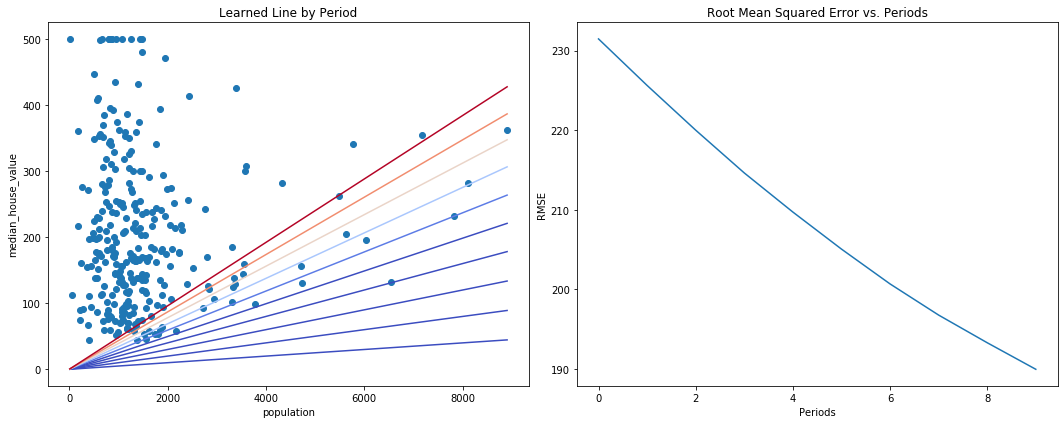

In [54]:
train_model_pop(
    learning_rate=0.00002,
    steps=500,
    batch_size=1
    )